In [1]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

In [3]:
_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname='flower_photos.tgz',
                                   extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
print(base_dir)

/home/ubuntu/.keras/datasets/flower_photos


In [4]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [5]:
import glob, shutil
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images=glob.glob(img_path + '/*.jpg')
    print('{}: {} Images'.format(cl, len(images)))
    train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
                                                               
    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        shutil.move(t, os.path.join(base_dir, 'train', cl))
    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        shutil.move(v, os.path.join(base_dir, 'val', cl))           

roses: 641 Images


Error: Destination path '/home/ubuntu/.keras/datasets/flower_photos/train/roses/14810868100_87eb739f26_m.jpg' already exists

In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [22]:
# data augmentation
BATCH_SIZE = 100
IMG_SHAPE = 150

image_gen = ImageDataGenerator(rescale=1.0/255, 
                               horizontal_flip=True,
                              )
train_data_gen = image_gen.flow_from_directory(batch_size = BATCH_SIZE, 
                                                directory=train_dir, 
                                                shuffle = True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='sparse'
                                               )

Found 2935 images belonging to 5 classes.


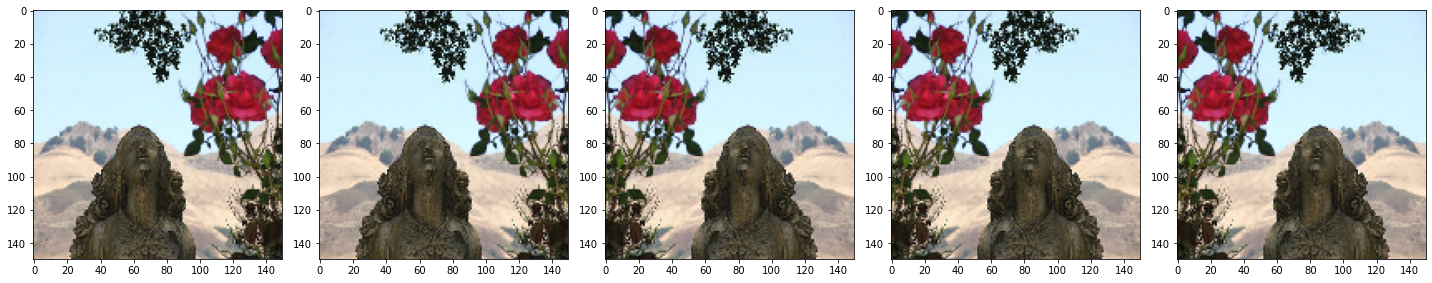

In [23]:
def plotImages(images_arr):
    fig, axes=plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2935 images belonging to 5 classes.


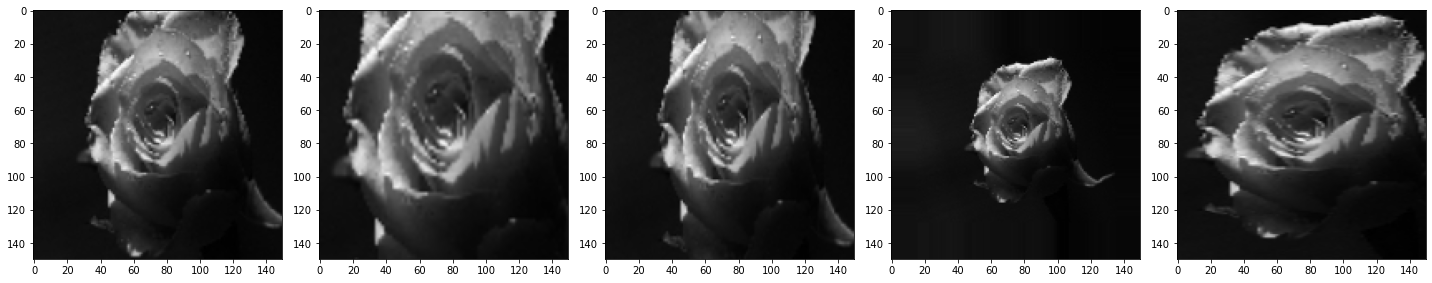

In [11]:
image_gen = ImageDataGenerator(rescale=1.0/255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size = (IMG_SHAPE, IMG_SHAPE),
                                               class_mode='sparse')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2935 images belonging to 5 classes.


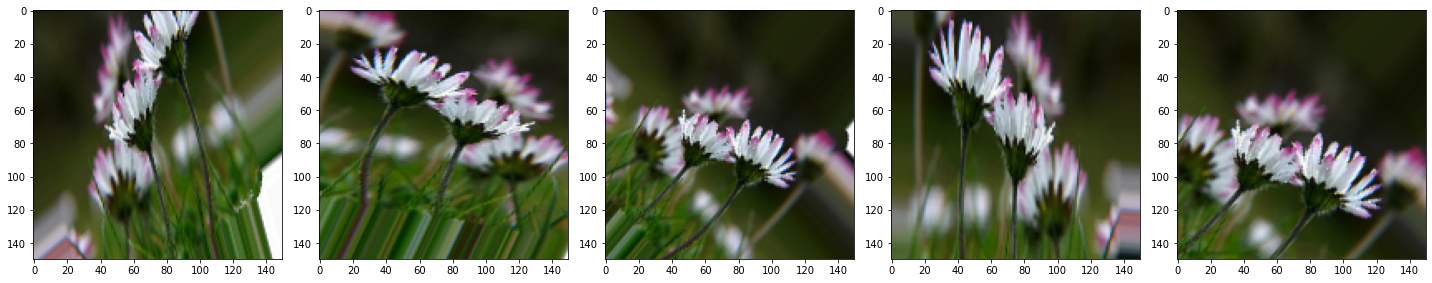

In [24]:
image_gen = ImageDataGenerator(rescale = 1.0/255, 
                               zoom_range= 0.5,
                               width_shift_range = 0.15,
                               height_shift_range = 0.15,
                               horizontal_flip = True,
                               rotation_range= 45,
                               #fill_mode='nearest'
                              )
train_data_gen  = image_gen.flow_from_directory(batch_size = BATCH_SIZE, 
                                                directory=train_dir, 
                                                shuffle = True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='sparse'
                                               )
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [36]:
# Data generator for validation set
image_gen_val = ImageDataGenerator(rescale = 1.0/255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=val_dir,
                                             shuffle=True,
                                             target_size=(IMG_SHAPE, IMG_SHAPE),
                                             class_mode='sparse'
                                            )

Found 735 images belonging to 5 classes.


In [35]:
no_train_data = sum(len(files) for _, _, files in os.walk(train_dir))
no_val_data = sum(len(files) for _,_, files in os.walk(val_dir))

print('No of train images, ', no_train_data)
print('No of val images, ', no_val_data)

No of train images,  2935
No of val images,  735


In [50]:
# create the CNN model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model
        

In [51]:
EPOCHS = 80
#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

#with strategy.scope():# model creation
model = create_model()
history = model.fit(train_data_gen, 
                    validation_data=val_data_gen, 
                    steps_per_epoch=int(np.ceil(no_train_data/ float(BATCH_SIZE))), 
                    epochs = EPOCHS, 
                    validation_steps=int(np.ceil(no_val_data/ float(BATCH_SIZE))),
                    batch_size = BATCH_SIZE
                   )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 64)      

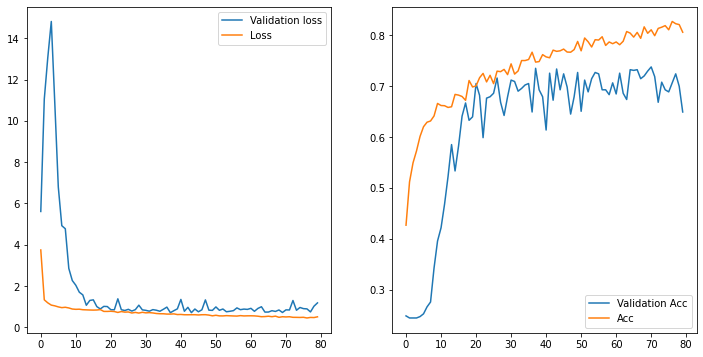

In [49]:
def plot_train(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(EPOCHS)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_acc, label='Validation Acc')
    plt.plot(epochs_range, acc, label='Acc')
    plt.legend(loc='lower right')
    
    plt.subplot(1,2,1)
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.plot(epochs_range, loss, label='Loss')
    plt.legend(loc='upper right')

    
    plt.show()
    plt.close()
    
plot_train(history)
    